<a href="https://colab.research.google.com/github/zhus-dika/computer_vision_home_works/blob/main/hw4_face_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **HW4**. Ты узнаешь её из тысячи

(надеюсь, это пропелось у вас в голове)

Итак, в рамках данного задания вам надо будет обучить модельку для распознавания лиц (а тестировать её будем на задаче верификации).

Если ещё не смотрели материалы курса по этом теме, сейчас самое время.

**Что тут будет**:
- поработаем с открытыми сетами [CASIA-WebFace](https://paperswithcode.com/dataset/casia-webface) и [LFW](https://vis-www.cs.umass.edu/lfw/)
- а ещё с любимыми модельками (из torchvision/timm, as you wish)
- прикрутим `arcface` (на этом моменте уже точно надо посмотреть материалы занятий)

In [ ]:
! pip install timm # это опция
! pip install mxnet mxnet-mkl==1.6.0 numpy==1.23.1 # это нужно будет

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━

In [ ]:
import sys
import os
import torch
import sklearn
import sklearn.metrics
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import timm
import pandas as pd
import PIL
from PIL import Image


import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'bilinear'
plt.rcParams['image.cmap'] = 'gray'

%matplotlib inline
%load_ext autoreload
%autoreload 2

## **1. CASIA-WebFace**

Для упрощения жизни будем юзать [insightface](https://github.com/deepinsight/insightface) - это лучший open-source репозиторий с модельками и скриптами для распонавания лиц. Используя только их можно получить уже оч приличные результаты, почти не страдая.

In [ ]:
! git clone https://github.com/deepinsight/insightface.git

Cloning into 'insightface'...
remote: Enumerating objects: 10448, done.
remote: Counting objects: 100% (826/826), done.
remote: Compressing objects: 100% (327/327), done.
remote: Total 10448 (delta 469), reused 751 (delta 444), pack-reused 9622
Receiving objects: 100% (10448/10448), 31.14 MiB | 13.10 MiB/s, done.
Resolving deltas: 100% (5702/5702), done.


Данные для обучения у них же можно взять в [Dataset Zoo](https://github.com/deepinsight/insightface/tree/master/recognition/_datasets_), нам нужны `CASIA-Webface (10K ids/0.5M images)`.

Дальше как обычно маунтите их в колабе, или если работаете локально, то просто к папкам обращайтесь.

Я тут для колаба как обычно пример оставлю.


In [ ]:
from google.colab import drive

drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
!unzip -q '/content/gdrive/MyDrive/hse/comp_vision/face_recognition/faces_webface_112x112.zip' -d './'

Датасет тут странно немножко выглядит, не пугайтесь.

`Dataloader` из `insightface` умеет с ним работать, возьмем его просто.

In [ ]:
sys.path.append('insightface/recognition/arcface_torch')
from insightface.recognition.arcface_torch.dataset import get_dataloader

/usr/local/lib/python3.10/dist-packages/torch/utils/_contextlib.py:125: UserWarning: Decorating classes is deprecated and will be disabled in future versions. You should only decorate functions or methods. To preserve the current behavior of class decoration, you can directly decorate the `__init__` method and nothing else.
  warnings.warn("Decorating classes is deprecated and will be disabled in "


In [ ]:
# https://github.com/deepinsight/insightface/blob/32682e54e08f36216bdf82dd9e03512c63cbac5c/recognition/arcface_torch/dataset.py#L19
train_loader = get_dataloader(
    root_dir='faces_webface_112x112',
    local_rank=0,
    batch_size=32,
    num_workers=2
)

In [ ]:
for imgs, labels in train_loader:
    print(imgs.shape)
    break

torch.Size([32, 3, 112, 112])


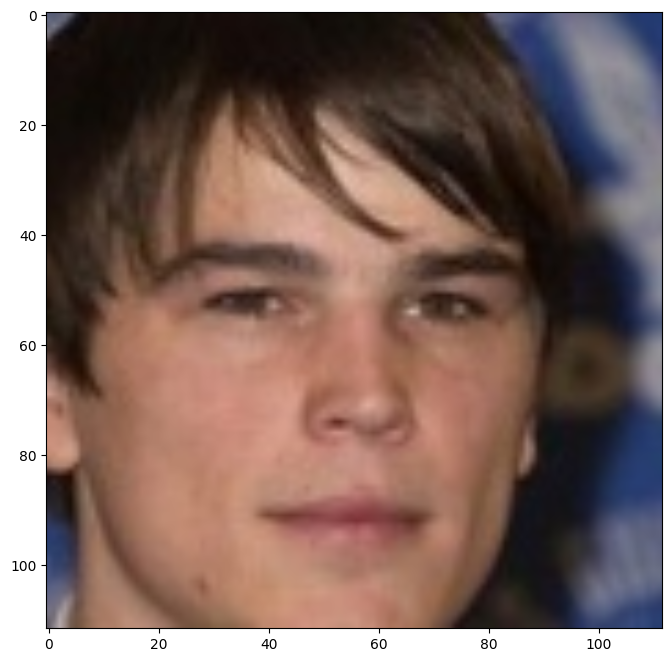

In [ ]:
# посмотрим что там у нас
plt.imshow(((imgs[1] + 1) / 2).detach().cpu().numpy().transpose(1, 2, 0))
plt.show()

Ну что, в датасете правда лица!

Для обучения можете использовать его в целом как угодно - целиком, частями, как-то ещё меняя процедуру аугментации и подготовки картинок - всё as you wish.

## **2. Model, loss, optimizer**

Это вам для старта, дальше меняйте как угодно

**Задание 0** (1 балл). Выберите параметры для первой модели

In [ ]:
# # у нас 10572 id, столько классов и берем, а вообще пишите тут какую хотите сетку
model = timm.create_model('resnet18', pretrained=True, num_classes=10572).cuda()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

In [ ]:
lr = 3e-04
weight_decay = 1e-05

In [ ]:
loss_CE = nn.CrossEntropyLoss()

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

In [ ]:
EPOCHS = 1

## **3. Train loop**

In [ ]:
step = 0
n_steps = EPOCHS * len(train_loader)

for epoch in range(EPOCHS):
    for imgs, labels in train_loader:
        optimizer.zero_grad()

        output = model(imgs)

        loss = loss_CE(output, labels)
        loss.backward()

        optimizer.step()

        step += 1
        if step % 100 == 0:
            print(f'Step {step}/{n_steps}, loss {loss}')

Step 100/15331, loss 9.146551132202148
Step 200/15331, loss 9.209555625915527
Step 300/15331, loss 9.06261920928955
Step 400/15331, loss 8.996631622314453
Step 500/15331, loss 8.868497848510742
Step 600/15331, loss 9.323580741882324
Step 700/15331, loss 8.8341703414917
Step 800/15331, loss 9.305493354797363
Step 900/15331, loss 8.757838249206543
Step 1000/15331, loss 8.78288745880127
Step 1100/15331, loss 8.517362594604492
Step 1200/15331, loss 8.619359970092773
Step 1300/15331, loss 8.768054008483887
Step 1400/15331, loss 8.770687103271484
Step 1500/15331, loss 8.752898216247559
Step 1600/15331, loss 8.148553848266602
Step 1700/15331, loss 8.47647476196289
Step 1800/15331, loss 8.571945190429688
Step 1900/15331, loss 8.444580078125
Step 2000/15331, loss 8.152737617492676
Step 2100/15331, loss 7.379003047943115
Step 2200/15331, loss 8.40330982208252
Step 2300/15331, loss 8.321396827697754
Step 2400/15331, loss 8.145841598510742
Step 2500/15331, loss 7.677622318267822
Step 2600/15331, l

После обучения нам станет не нужен последний слой, будут интересны только дескрипторы.

Так что от последнего надо будет как-то избавиться.

In [ ]:
class Identity(torch.nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x

In [ ]:
# вот так изящно можно выкинуть последний слой и теперь на выход у вас пойдет дескриптор
model.fc = Identity()

In [ ]:
torch.save(model, '/content/gdrive/MyDrive/hse/comp_vision/face_recognition/model.pth')

## **4. Test model**

Давайте визуально чекнем, что всё норм просто на одном батче (последнем из трейна, какие мы нехорошие)

In [ ]:
# такой класс можно использовать просто для удобства работы и перехода к тестам
class Classifier:
    def __init__(self, model_path):
        self.model = torch.load(model_path)
        self.model.eval()

    def calculate_descriptors(self, imgs):
        return self.model(imgs)

In [ ]:
# получаем дескрипторы и перекладываем их на cpu
classifier = Classifier('/content/gdrive/MyDrive/hse/comp_vision/face_recognition/model.pth')
descriptors = classifier.calculate_descriptors(imgs)
descriptors = descriptors.detach().cpu().numpy()

# внутри модели мы пока никак не нормализовали дескрипторы, поэтому это нужно сделать здесь
descriptors = sklearn.preprocessing.normalize(descriptors)
print(descriptors.shape)

(32, 512)


In [ ]:
# посчитаем попарные расстояния между ними
distances = sklearn.metrics.pairwise_distances(descriptors) #тут l2 по умолчанию
print(distances.shape)

(32, 32)


In [ ]:
# значения под главной диагональю сделаем слишком большими (они дублируются над ней)
distances[np.tril_indices(distances.shape[0])] = np.inf

In [ ]:
# находим пары, между которыми расстояния наименьшие
min_idxs = np.unravel_index(distances.argmin(), distances.shape)

In [ ]:
distances[min_idxs]

0.739517

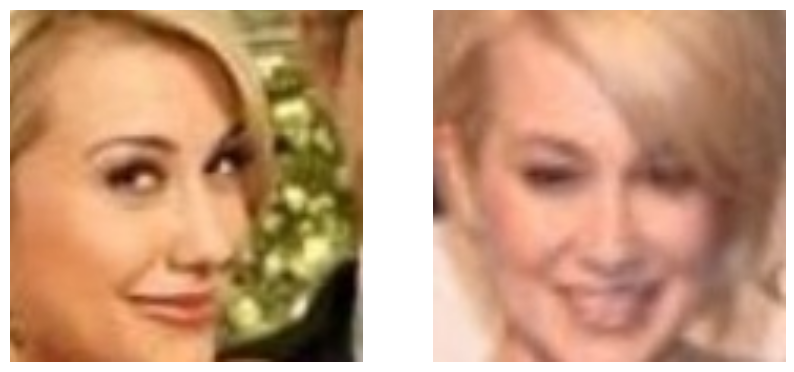

In [ ]:
plt.subplot(1, 2, 1)
plt.imshow(((imgs[min_idxs[0]] + 1) / 2).detach().cpu().numpy().transpose(1, 2, 0))
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(((imgs[min_idxs[1]] + 1) / 2).detach().cpu().numpy().transpose(1, 2, 0))
plt.axis('off')
plt.show()

In [ ]:
# а теперь пусть будут слишком маленькими
distances[np.tril_indices(distances.shape[0])] = -np.inf

In [ ]:
# а мы найдем пары с самыми далекими дескрипторами - расстояние между ними наибольшее
max_idxs = np.unravel_index(distances.argmax(), distances.shape)

In [ ]:
distances[max_idxs]

1.2616622

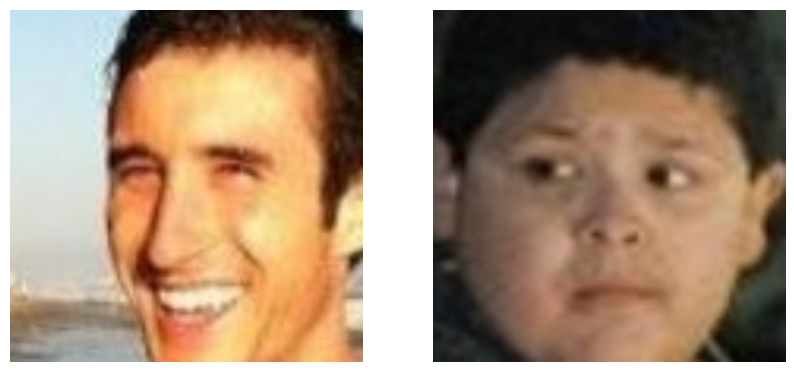

In [ ]:
plt.subplot(1, 2, 1)
plt.imshow(((imgs[max_idxs[0]] + 1) / 2).detach().cpu().numpy().transpose(1, 2, 0))
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(((imgs[max_idxs[1]] + 1) / 2).detach().cpu().numpy().transpose(1, 2, 0))
plt.axis('off')
plt.show()

Уу, какая классная у нас модель.

## **5. А что делать то**

Итак, модельки мы учить умеем. А на чем их тестировать?

Тестироваться будем на [LFW - Labeled Faces in the Wild](https://vis-www.cs.umass.edu/lfw/#views). Данные для теста берем по [ссылке здесь](https://drive.google.com/file/d/1OFzigMziGErlAXBKHPiyExambS8Q55kn/view?usp=sharing).

**Что там есть что**:

  - **Image file format**: формат имен картинок - "lfw/name/name_xxxx.jpg" где "xxxx" это номер изображения, подбитый нулями до длины 4. Например, 10е изображения George_W_Bush будет называться "lfw/George_W_Bush/George_W_Bush_0010.jpg"

  - **Image dimensions**: каждая картинка - 250x250 jpg, картинки приведены к единому размеру и выровнены.

  - **peopleDevTest.csv**: список всех людей и их фоток: в тесте 1711 человек и 3708 фото.

  - **matchpairsDevTest.csv**: список 500 matched пар для тестирования.

  - **mismatchpairsDevTest.csv**: список 500 mismatched пар для тестирования.

(не все картинки в парах будут задействованы в тестировании).

**Задание 1** (3 балла). Разберитесь с тестовыми датасетом, подготовьте код, для того, чтобы тестироваться на нем (надо будет извлекать на них дескрипторы, и процесс подготовки наверное должен быть похож на тот, что был у CasiaWeb).

## Solution Task #1

### Prepare dataloader

In [ ]:
#!unzip -q '/content/gdrive/MyDrive/hse/comp_vision/face_recognition/LFW.zip' -d './'


In [ ]:
# the training transforms
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    transforms.RandomRotation(degrees=(30, 70)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    )
])
# the validation transforms
valid_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    )
])

In [ ]:
BATCH_SIZE = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# training dataset
train_dataset = datasets.ImageFolder(
    #root='./archive/lfw',
    root = '/kaggle/input/lfw-face-recognition/archive/lfw',
    transform=train_transform
)
# # validation dataset
# valid_dataset = datasets.ImageFolder(
#     root='input/butterflies_rev2/valid',
#     transform=valid_transform
# )
# training data loaders
train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=4, pin_memory=True
)
# validation data loaders
# valid_loader = DataLoader(
#     valid_dataset, batch_size=BATCH_SIZE, shuffle=False,
#     num_workers=4, pin_memory=True
# )

In [ ]:
for imgs, labels in train_loader:
    print(imgs.shape)
    break

torch.Size([64, 3, 250, 250])


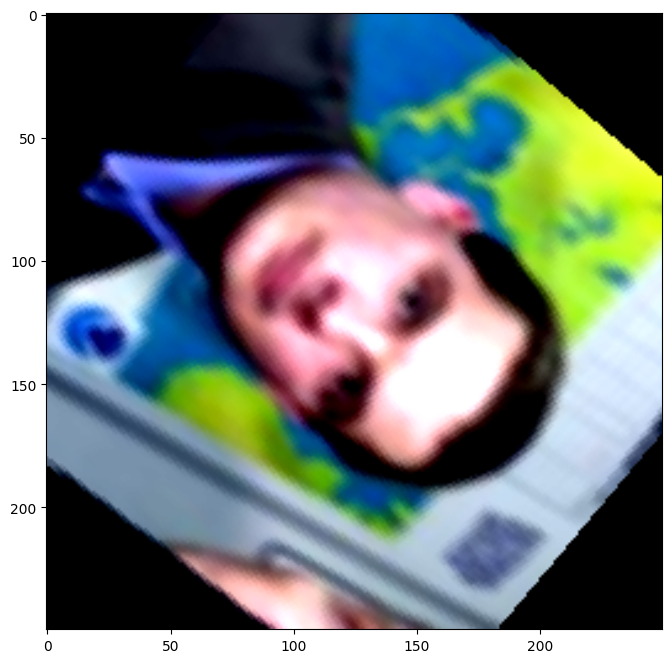

In [ ]:
# посмотрим что там у нас
plt.imshow(((imgs[0] + 1) / 2).detach().cpu().numpy().transpose(1, 2, 0))
plt.show()

### Prepare training

In [ ]:
! ls /kaggle/input/lfw-face-recognition/archive/lfw  | wc -l

5749


https://tfimm.readthedocs.io/en/latest/content/efficientnet.html

In [ ]:
#resnext101_32x8d
model = timm.create_model('resnext101_32x4d', pretrained=True, num_classes=5749).to(device=device)

model.safetensors:   0%|          | 0.00/177M [00:00<?, ?B/s]

In [ ]:
lr = 3e-04
weight_decay = 1e-05

loss_CE = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0)

EPOCHS = 30

### Training

In [ ]:
step = 0
n_steps = EPOCHS * len(train_loader)

for epoch in range(EPOCHS):
    for imgs, labels in train_loader:
        optimizer.zero_grad()

        imgs = imgs.to(device=device)
        labels = labels.to(device=device)
        output = model(imgs)

        loss = loss_CE(output, labels)
        loss.backward()

        optimizer.step()

        scheduler.step()

        step += 1
        if step % 100 == 0:
            print(f'Step {step}/{n_steps}, loss {loss}')

Step 100/6210, loss 8.390650749206543
Step 200/6210, loss 9.045880317687988
Step 300/6210, loss 7.190953254699707
Step 400/6210, loss 7.825798988342285
Step 500/6210, loss 7.547727584838867
Step 600/6210, loss 7.9418816566467285
Step 700/6210, loss 7.091870307922363
Step 800/6210, loss 7.794487476348877
Step 900/6210, loss 7.06419038772583
Step 1000/6210, loss 7.593811511993408
Step 1100/6210, loss 6.9179277420043945
Step 1200/6210, loss 6.9289398193359375
Step 1300/6210, loss 6.606161117553711
Step 1400/6210, loss 6.6095805168151855
Step 1500/6210, loss 6.06705379486084
Step 1600/6210, loss 5.710988521575928
Step 1700/6210, loss 5.711846828460693
Step 1800/6210, loss 5.451543807983398
Step 1900/6210, loss 5.392984390258789
Step 2000/6210, loss 5.755402565002441
Step 2100/6210, loss 5.05354118347168
Step 2200/6210, loss 5.198201656341553
Step 2300/6210, loss 4.784358501434326
Step 2400/6210, loss 4.9558258056640625
Step 2500/6210, loss 4.5518412590026855
Step 2600/6210, loss 5.13221693

In [ ]:
# вот так изящно можно выкинуть последний слой и теперь на выход у вас пойдет дескриптор
model.fc = Identity()

torch.save(model, '/kaggle/working/model_lfw.pth')

In [ ]:
# получаем дескрипторы и перекладываем их на cpu
classifier = Classifier('/kaggle/working/model_lfw.pth')

**Задание 2** (3 балла). Напишите процедуру тестирования и подсчета метрики для верификации.

Для оценки качества на задачу мы можем смотреть просто как на бинарную классификацию, где `match` пара - 1, `mismatch` - 0. То есть фактически мы тут решаем задачу **бинарной классификации**, но **для пар картинок**.

На [papers with code](https://paperswithcode.com/sota/face-verification-on-labeled-faces-in-the) для такого простого сета используют `accuracy`. Вы сделайте также и протестируйте обученную модель на сете.

## Solution Task #2

### Testing

In [ ]:
classifier = Classifier('/kaggle/working/model_lfw.pth')

match_pairs_df = pd.read_csv('/kaggle/input/lfw-face-recognition/archive/matchpairsDevTest.csv')
mismatch_pairs_df = pd.read_csv('/kaggle/input/lfw-face-recognition/archive/mismatchpairsDevTest.csv')
mismatch_pairs_df.head()

,name,imagenum1,name.1,imagenum2
0,AJ_Lamas,1,Zach_Safrin,1
1,Aaron_Guiel,1,Reese_Witherspoon,3
2,Aaron_Tippin,1,Jose_Luis_Rodriguez_Zapatero,1
3,Abdul_Majeed_Shobokshi,1,Charles_Cope,1
4,Abdullah_Gul,16,Steve_Cox,1


In [ ]:
th = 0.76

In [ ]:
str_zeros = '0000'
acc = 0
for index, row in match_pairs_df.iterrows():
    img1_str = str(row['imagenum1'])
    img2_str = str(row['imagenum2'])
    len_img1 = len(img1_str)
    len_img2 = len(img2_str)
    img1_path = os.path.join('/kaggle/input/lfw-face-recognition/archive/lfw', row['name'], row['name'] + '_' + str_zeros[:4-len_img1] + img1_str + '.jpg')
    img2_path = os.path.join('/kaggle/input/lfw-face-recognition/archive/lfw', row['name'], row['name'] + '_' + str_zeros[:4-len_img2] + img2_str + '.jpg')
    img1 = valid_transform(Image.open(img1_path)).unsqueeze(0).to(device=device)
    img2 = valid_transform(Image.open(img2_path)).unsqueeze(0).to(device=device)
    cat_imgs = torch.cat([img1, img2], dim=0)
    descriptors = classifier.calculate_descriptors(cat_imgs)
    descriptors = descriptors.detach().cpu().numpy()
    descriptors = sklearn.preprocessing.normalize(descriptors)
    distances = sklearn.metrics.pairwise_distances(descriptors) #тут l2 по умолчанию
    if max(distances[0]) < th:
        acc += 1

In [ ]:
match_acc = acc / 500
match_acc

0.878

In [ ]:
acc = 0
str_zeros = '0000'
for index, row in mismatch_pairs_df.iterrows():
    img1_str = str(row['imagenum1'])
    img2_str = str(row['imagenum2'])
    len_img1 = len(img1_str)
    len_img2 = len(img2_str)
    img1_path = os.path.join('/kaggle/input/lfw-face-recognition/archive/lfw', row['name'], row['name'] + '_' + str_zeros[:4-len_img1] + img1_str + '.jpg')
    img2_path = os.path.join('/kaggle/input/lfw-face-recognition/archive/lfw', row['name.1'], row['name.1'] + '_' + str_zeros[:4-len_img2] + img2_str + '.jpg')
    img1 = valid_transform(Image.open(img1_path)).unsqueeze(0).to(device=device)
    img2 = valid_transform(Image.open(img2_path)).unsqueeze(0).to(device=device)
    cat_imgs = torch.cat([img1, img2], dim=0)
    descriptors = classifier.calculate_descriptors(cat_imgs)
    descriptors = descriptors.detach().cpu().numpy()
    descriptors = sklearn.preprocessing.normalize(descriptors)
    distances = sklearn.metrics.pairwise_distances(descriptors) #тут l2 по умолчанию
    if max(distances[0]) > th:
        acc += 1

In [ ]:
mismatch_acc = acc / 500
mismatch_acc

0.888

In [ ]:
np.mean([match_acc, mismatch_acc])

0.883

**Задание 3**. А теперь улучшаемся :)

(1 балл) `accuracy > 0.98`

(1 балл) `accuracy > 0.985`

(1 балл) `accuracy > 0.99`